In [21]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
import glob
import os
import csv
from datetime import datetime, timedelta, date

[nltk_data] Downloading package punkt to /Users/lizheng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
main_folder = 'apple_news_1/'
def get_filename(path):
    filenames = []
    files = [i.path for i in os.scandir(path) if i.is_file()]
    for filename in files:
        filename = os.path.basename(filename)
        filenames.append(filename)
    return filenames


files = get_filename(main_folder)

# with open('some.csv', 'w', newline = '') as csv_file:
lst_documents = []
for _file in files:
    # lst_documents = []
    file_name = _file
    lst = []
    with open(main_folder + _file,'r') as f:
        for lines in f:
            lst.append(lines.replace("\n", "").strip().replace("•",""))
            # text = f.read()
            # writer = csv.writer(csv_file)
            # writer.writerow([file_name, lst])
        lst = " ".join(lst)
    lst_documents.append(lst)

    
df = pd.DataFrame(data = {"Report": files, "content": lst_documents})
df_date = pd.read_csv("dates.csv", index_col=[0]).rename(columns = {"name": "Report"})
df_date["Report"] = df_date["Report"].apply(lambda x: x + ".txt")
df = pd.merge(df, df_date, on = "Report")
# df["date"] = df["date"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
# df["date"] = df["date"].dt.strftime("%m/%d/%y")
# df = df.sort_values(by="Date").reset_index(drop = True)
# df

In [23]:
df

,Report,content,date
0,Apple Sues NSO Group to Curb the Abuse of Stat...,Apple also announced a $10 million contributio...,2021-11-23
1,All-New iMac Features Stunning Design in a Spe...,"iMac offers the best camera, mics, and speaker...",2021-04-20
2,Apple introduces the News Partner Program.txt,"CUPERTINO, Calif., August 26, 2021--(BUSINESS ...",2021-08-26
3,S&P 500 Buybacks Set A Record High.txt,"S&P 500 Q3 2021 buybacks were $234.6 billion, ...",2021-12-21
4,Apple Watch Pride Edition Bands Celebrate and ...,New Braided Solo Loop represents the breadth o...,2021-05-17
5,Introducing M1 Pro and M1 Max: the most powerf...,"Powering the all-new MacBook Pro, new chips fe...",2021-10-18
6,Japan Fair Trade Commission Closes App Store I...,"Apple will let developers of ""reader"" apps aro...",2021-09-01
7,Apple introduces the Apple Music Voice Plan.txt,"The new music experience, designed exclusively...",2021-10-18
8,"New Features in Keynote, Pages, and Numbers En...",Keynote adds new tools for collaborative prese...,2021-09-28
9,Apple Changsha Opens Saturday in China.txt,"CHANGSHA, China, September 02, 2021--(BUSINESS...",2021-09-01


In [24]:
df_apple = pd.read_csv("old_AAPL_labels.csv").T
df_apple.columns = df_apple.iloc[0]
df_apple = df_apple[1:]
df_apple.reset_index().to_csv("apple_label.csv")
df_apple = pd.read_csv("apple_label.csv", index_col=0)
df_apple = df_apple.rename(columns = {"index": "date"})
df_apple["date"] = df_apple["date"].apply(lambda x: datetime.strptime(str(x), "%Y-%m-%d"))
df["date"] = df["date"].apply(lambda x: datetime.strptime(str(x), "%Y-%m-%d"))
new_df = pd.merge(df, df_apple, how='outer', on='date').dropna()

In [25]:
new_df

,Report,content,date,Initial Price,5 days,5 days label,10 days,10 days label,20 days,20 days label,60 days,60 days label
0,Apple Sues NSO Group to Curb the Abuse of Stat...,Apple also announced a $10 million contributio...,2021-11-23,161.410004,161.140002,False,163.257001,True,168.669474,True,168.669474,True
1,All-New iMac Features Stunning Design in a Spe...,"iMac offers the best camera, mics, and speaker...",2021-04-20,132.492126,132.898227,True,132.685220,True,129.628589,False,131.009152,False
2,Apple introduces the News Partner Program.txt,"CUPERTINO, Calif., August 26, 2021--(BUSINESS ...",2021-08-26,147.324982,150.500351,True,152.519405,True,149.631118,True,147.895232,True
4,Apple Watch Pride Edition Bands Celebrate and ...,New Braided Solo Loop represents the breadth o...,2021-05-17,125.897354,125.339008,False,125.557360,False,125.716390,False,136.125182,True
5,Introducing M1 Pro and M1 Max: the most powerf...,"Powering the all-new MacBook Pro, new chips fe...",2021-10-18,146.336426,148.331512,True,148.974579,True,149.430466,True,158.383541,True
6,Apple introduces the Apple Music Voice Plan.txt,"The new music experience, designed exclusively...",2021-10-18,146.336426,148.331512,True,148.974579,True,149.430466,True,158.383541,True
7,Game-changing MacBook Pro with M1 Pro and M1 M...,"The new MacBook Pro features a 1080p camera, t...",2021-10-18,146.336426,148.331512,True,148.974579,True,149.430466,True,158.383541,True
8,Final Cut Pro and Logic Pro updated with power...,Final Cut Pro delivers huge advances in 8K vid...,2021-10-18,146.336426,148.331512,True,148.974579,True,149.430466,True,158.383541,True
9,Japan Fair Trade Commission Closes App Store I...,"Apple will let developers of ""reader"" apps aro...",2021-09-01,152.287735,154.226910,True,151.978192,False,148.429871,False,148.640332,False
10,Apple Changsha Opens Saturday in China.txt,"CHANGSHA, China, September 02, 2021--(BUSINESS...",2021-09-01,152.287735,154.226910,True,151.978192,False,148.429871,False,148.640332,False


In [26]:
new_df["5 days label"] = new_df["5 days label"].astype(int)
new_df["10 days label"] = new_df["10 days label"].astype(int)
new_df["20 days label"] = new_df["20 days label"].astype(int)
new_df["60 days label"] = new_df["60 days label"].astype(int)

In [27]:
new_df

,Report,content,date,Initial Price,5 days,5 days label,10 days,10 days label,20 days,20 days label,60 days,60 days label
0,Apple Sues NSO Group to Curb the Abuse of Stat...,Apple also announced a $10 million contributio...,2021-11-23,161.410004,161.140002,0,163.257001,1,168.669474,1,168.669474,1
1,All-New iMac Features Stunning Design in a Spe...,"iMac offers the best camera, mics, and speaker...",2021-04-20,132.492126,132.898227,1,132.685220,1,129.628589,0,131.009152,0
2,Apple introduces the News Partner Program.txt,"CUPERTINO, Calif., August 26, 2021--(BUSINESS ...",2021-08-26,147.324982,150.500351,1,152.519405,1,149.631118,1,147.895232,1
4,Apple Watch Pride Edition Bands Celebrate and ...,New Braided Solo Loop represents the breadth o...,2021-05-17,125.897354,125.339008,0,125.557360,0,125.716390,0,136.125182,1
5,Introducing M1 Pro and M1 Max: the most powerf...,"Powering the all-new MacBook Pro, new chips fe...",2021-10-18,146.336426,148.331512,1,148.974579,1,149.430466,1,158.383541,1
6,Apple introduces the Apple Music Voice Plan.txt,"The new music experience, designed exclusively...",2021-10-18,146.336426,148.331512,1,148.974579,1,149.430466,1,158.383541,1
7,Game-changing MacBook Pro with M1 Pro and M1 M...,"The new MacBook Pro features a 1080p camera, t...",2021-10-18,146.336426,148.331512,1,148.974579,1,149.430466,1,158.383541,1
8,Final Cut Pro and Logic Pro updated with power...,Final Cut Pro delivers huge advances in 8K vid...,2021-10-18,146.336426,148.331512,1,148.974579,1,149.430466,1,158.383541,1
9,Japan Fair Trade Commission Closes App Store I...,"Apple will let developers of ""reader"" apps aro...",2021-09-01,152.287735,154.226910,1,151.978192,0,148.429871,0,148.640332,0
10,Apple Changsha Opens Saturday in China.txt,"CHANGSHA, China, September 02, 2021--(BUSINESS...",2021-09-01,152.287735,154.226910,1,151.978192,0,148.429871,0,148.640332,0


In [28]:
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text

In [29]:
new_df['content'] = df['content'].apply(cleanText)
train, test = train_test_split(new_df, test_size=0.000001 , random_state=42)


def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize_text(r['content']), tags=[r["5 days label"]]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=tokenize_text(r['content']), tags=[r["5 days label"]]), axis=1)

# The maximum number of words to be used. (most frequent)
max_fatures = 500000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50

#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(new_df['content'].values)
X = tokenizer.texts_to_sequences(new_df['content'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Found %s unique tokens.' % len(X))

Found 24 unique tokens.


In [37]:
X.tolist().to_array()

AttributeError: 'list' object has no attribute 'to_array'

In [10]:
X.shape

(24, 50)

In [11]:
d2v_model = Doc2Vec(dm=1, dm_mean=1, vector_size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

100%|███████████████████████████████████████| 23/23 [00:00<00:00, 166613.11it/s]


In [12]:
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|███████████████████████████████████████| 23/23 [00:00<00:00, 591834.31it/s]


CPU times: user 657 ms, sys: 29.2 ms, total: 686 ms
Wall time: 673 ms


In [13]:
print(d2v_model)

Doc2Vec(dm/m,d20,n5,w8,s0.001)


In [14]:
len(d2v_model.wv.index_to_key)

5134

In [15]:
embedding_matrix = np.zeros((len(d2v_model.wv.key_to_index) + 1, 20))

# for i, vec in enumerate(d2v_model.wv):
#     # while i <= 3:
#     # print(i)
#     # print(vec)
#     #print(model.docvecs)
#     embedding_matrix[i]=vec
#     if i == 11681:
#         break
#     #print(vec)
#     #print(vec[i])

In [16]:
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [17]:
len(embedding_matrix)

5135

In [18]:
d2v_model.dv

In [19]:
len(d2v_model.dv)

2

In [20]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding

In [21]:
model = Sequential()

# emmbed word vectors
model.add(Embedding(len(d2v_model.wv.key_to_index)+1,20,input_length=X.shape[1], weights=[embedding_matrix], trainable=True))

# learn the correlations
def split_input(sequence):
     return sequence[:-1], tf.reshape(sequence[1:], (-1,1))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(2,activation="softmax"))

# output model skeleton
model.summary()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['acc'])

2022-03-06 20:32:05.776236: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-06 20:32:05.776394: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 20)            102700    
_________________________________________________________________
lstm (LSTM)                  (None, 50)                14200     
_________________________________________________________________
dense (Dense)                (None, 2)                 102       
Total params: 117,002
Trainable params: 117,002
Non-trainable params: 0
_________________________________________________________________


In [22]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [23]:
Y = pd.get_dummies(new_df['5 days label']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.95, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1, 50) (1, 2)
(23, 50) (23, 2)


In [24]:
batch_size = 32
history=model.fit(X_train, Y_train, epochs =50, batch_size=batch_size, verbose = 2)

Epoch 1/50


2022-03-06 20:32:06.128996: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-06 20:32:06.129205: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-06 20:32:06.545851: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-06 20:32:06.635739: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-06 20:32:06.779620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1/1 - 1s - loss: 0.6931 - acc: 0.0000e+00
Epoch 2/50
1/1 - 0s - loss: 0.6898 - acc: 1.0000
Epoch 3/50
1/1 - 0s - loss: 0.6862 - acc: 1.0000
Epoch 4/50
1/1 - 0s - loss: 0.6822 - acc: 1.0000
Epoch 5/50
1/1 - 0s - loss: 0.6776 - acc: 1.0000
Epoch 6/50
1/1 - 0s - loss: 0.6723 - acc: 1.0000
Epoch 7/50
1/1 - 0s - loss: 0.6662 - acc: 1.0000
Epoch 8/50
1/1 - 0s - loss: 0.6591 - acc: 1.0000
Epoch 9/50
1/1 - 0s - loss: 0.6507 - acc: 1.0000
Epoch 10/50
1/1 - 0s - loss: 0.6407 - acc: 1.0000
Epoch 11/50
1/1 - 0s - loss: 0.6285 - acc: 1.0000
Epoch 12/50
1/1 - 0s - loss: 0.6135 - acc: 1.0000
Epoch 13/50
1/1 - 0s - loss: 0.5946 - acc: 1.0000
Epoch 14/50
1/1 - 0s - loss: 0.5702 - acc: 1.0000
Epoch 15/50
1/1 - 0s - loss: 0.5380 - acc: 1.0000
Epoch 16/50
1/1 - 0s - loss: 0.4947 - acc: 1.0000
Epoch 17/50
1/1 - 0s - loss: 0.4362 - acc: 1.0000
Epoch 18/50
1/1 - 0s - loss: 0.3599 - acc: 1.0000
Epoch 19/50
1/1 - 0s - loss: 0.2718 - acc: 1.0000
Epoch 20/50
1/1 - 0s - loss: 0.1904 - acc: 1.0000
Epoch 21/50
1/1 

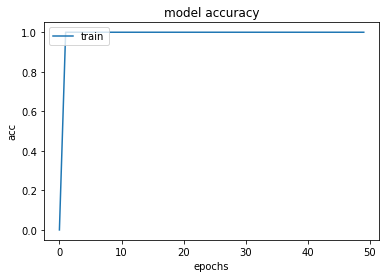

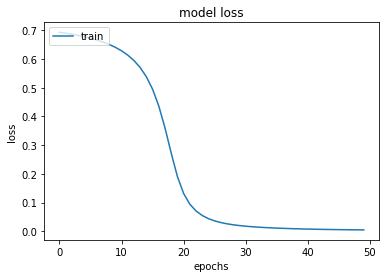

In [25]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_accuracy.png')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_loss.png')
plt.show()

In [26]:
# evaluate the model
_, train_acc = model.evaluate(X_train, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

1/1 - 0s - loss: 0.0045 - acc: 1.0000


2022-03-06 20:32:08.867053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-06 20:32:08.896764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1/1 - 0s - loss: 2.1740 - acc: 0.6087
Train: 1.000, Test: 0.6087


In [27]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
print(yhat_probs)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs,axis=1)
print(yhat_classes)
# reduce to 1d array
#yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 1]

[[1.55000671e-05 9.99984503e-01]
 [1.54872851e-05 9.99984503e-01]
 [1.49239822e-05 9.99985099e-01]
 [1.55004964e-05 9.99984503e-01]
 [1.55002108e-05 9.99984503e-01]
 [1.49177304e-05 9.99985099e-01]
 [1.54966237e-05 9.99984503e-01]
 [1.55029356e-05 9.99984503e-01]
 [1.55087473e-05 9.99984503e-01]
 [1.55001690e-05 9.99984503e-01]
 [1.54952922e-05 9.99984503e-01]
 [1.49162506e-05 9.99985099e-01]
 [1.55011421e-05 9.99984503e-01]
 [1.55006401e-05 9.99984503e-01]
 [1.54950467e-05 9.99984503e-01]
 [1.55033358e-05 9.99984503e-01]
 [1.49793295e-05 9.99984980e-01]
 [1.49271400e-05 9.99985099e-01]
 [1.53347628e-05 9.99984622e-01]
 [1.55005891e-05 9.99984503e-01]
 [1.55007638e-05 9.99984503e-01]
 [1.55016041e-05 9.99984503e-01]
 [1.55016442e-05 9.99984503e-01]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


2022-03-06 20:32:09.214260: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-03-06 20:32:09.236704: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [28]:
import numpy as np
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels

array([1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1])

In [29]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, yhat_classes)
cm

array([[ 0,  9],
       [ 0, 14]])

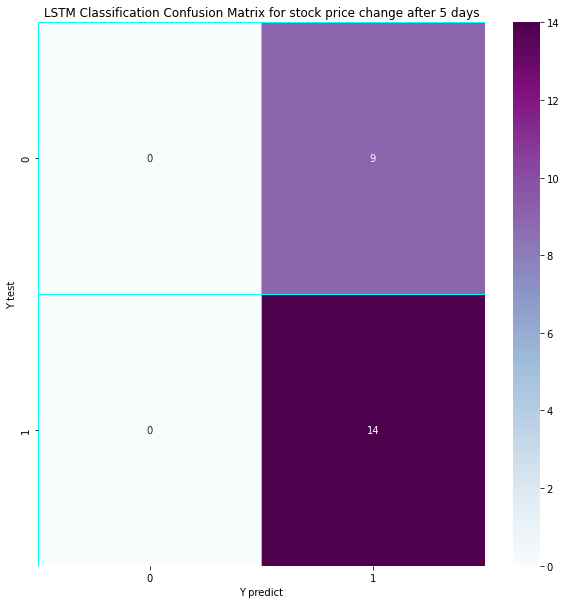

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix for stock price change after 5 days')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.savefig('LSTM Classification 5 days.png')
plt.show()

In [31]:
Y = pd.get_dummies(new_df['10 days label']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.95, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1, 50) (1, 2)
(23, 50) (23, 2)


In [32]:
batch_size = 32
history=model.fit(X_train, Y_train, epochs =50, batch_size=batch_size, verbose = 2)

Epoch 1/50
1/1 - 0s - loss: 0.0045 - acc: 1.0000
Epoch 2/50
1/1 - 0s - loss: 0.0044 - acc: 1.0000
Epoch 3/50
1/1 - 0s - loss: 0.0042 - acc: 1.0000
Epoch 4/50
1/1 - 0s - loss: 0.0040 - acc: 1.0000
Epoch 5/50
1/1 - 0s - loss: 0.0039 - acc: 1.0000
Epoch 6/50
1/1 - 0s - loss: 0.0038 - acc: 1.0000
Epoch 7/50
1/1 - 0s - loss: 0.0036 - acc: 1.0000
Epoch 8/50
1/1 - 0s - loss: 0.0035 - acc: 1.0000
Epoch 9/50
1/1 - 0s - loss: 0.0034 - acc: 1.0000
Epoch 10/50
1/1 - 0s - loss: 0.0033 - acc: 1.0000
Epoch 11/50
1/1 - 0s - loss: 0.0032 - acc: 1.0000
Epoch 12/50
1/1 - 0s - loss: 0.0031 - acc: 1.0000
Epoch 13/50
1/1 - 0s - loss: 0.0030 - acc: 1.0000
Epoch 14/50
1/1 - 0s - loss: 0.0030 - acc: 1.0000
Epoch 15/50
1/1 - 0s - loss: 0.0029 - acc: 1.0000
Epoch 16/50
1/1 - 0s - loss: 0.0028 - acc: 1.0000
Epoch 17/50
1/1 - 0s - loss: 0.0027 - acc: 1.0000
Epoch 18/50
1/1 - 0s - loss: 0.0027 - acc: 1.0000
Epoch 19/50
1/1 - 0s - loss: 0.0026 - acc: 1.0000
Epoch 20/50
1/1 - 0s - loss: 0.0025 - acc: 1.0000
Epoch 21/

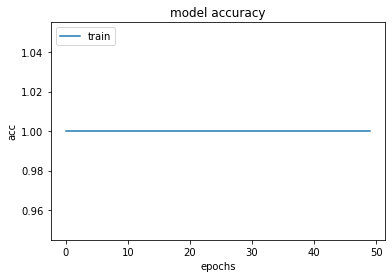

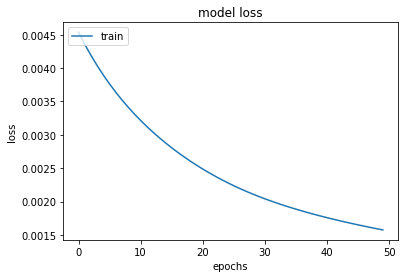

In [33]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_accuracy.png')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_loss.png')
plt.show()

In [34]:
# evaluate the model
_, train_acc = model.evaluate(X_train, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

1/1 - 0s - loss: 0.0016 - acc: 1.0000
1/1 - 0s - loss: 1.7139 - acc: 0.7391
Train: 1.000, Test: 0.7391


In [35]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
print(yhat_probs)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs,axis=1)
print(yhat_classes)
# reduce to 1d array
#yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 1]

[[2.0145521e-06 9.9999797e-01]
 [2.0126008e-06 9.9999797e-01]
 [1.9368931e-06 9.9999809e-01]
 [2.0145735e-06 9.9999797e-01]
 [2.0145708e-06 9.9999797e-01]
 [1.9364297e-06 9.9999809e-01]
 [2.0142486e-06 9.9999797e-01]
 [2.0147786e-06 9.9999797e-01]
 [2.0156072e-06 9.9999797e-01]
 [2.0145628e-06 9.9999797e-01]
 [2.0141074e-06 9.9999797e-01]
 [1.9386659e-06 9.9999809e-01]
 [2.0146454e-06 9.9999797e-01]
 [2.0146001e-06 9.9999797e-01]
 [2.0140701e-06 9.9999797e-01]
 [2.0148452e-06 9.9999797e-01]
 [1.9460899e-06 9.9999809e-01]
 [1.9373388e-06 9.9999809e-01]
 [1.9939346e-06 9.9999797e-01]
 [2.0145922e-06 9.9999797e-01]
 [2.0146188e-06 9.9999797e-01]
 [2.0146827e-06 9.9999797e-01]
 [2.0146906e-06 9.9999797e-01]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [36]:
import numpy as np
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels

array([0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

In [49]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, yhat_classes)
cm

array([[ 0,  7],
       [ 0, 16]])

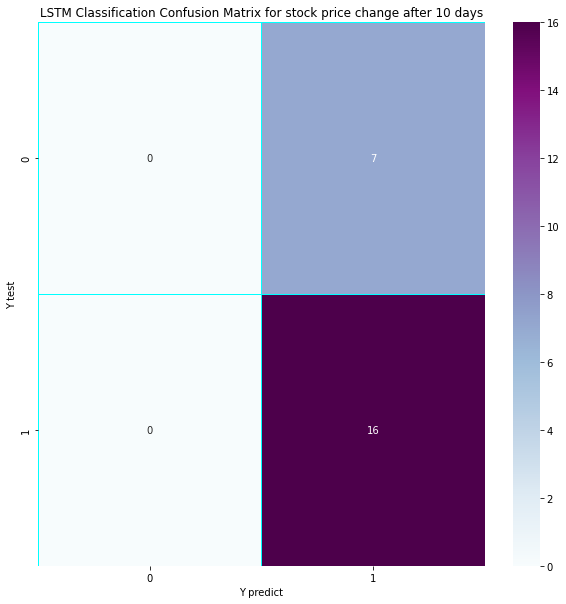

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix for stock price change after 10 days')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.savefig('LSTM Classification 10 days.png')
plt.show()

In [39]:
Y = pd.get_dummies(new_df['20 days label']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.95, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1, 50) (1, 2)
(23, 50) (23, 2)


In [40]:
batch_size = 32
history=model.fit(X_train, Y_train, epochs =50, batch_size=batch_size, verbose = 2)

Epoch 1/50
1/1 - 0s - loss: 0.0016 - acc: 1.0000
Epoch 2/50
1/1 - 0s - loss: 0.0015 - acc: 1.0000
Epoch 3/50
1/1 - 0s - loss: 0.0015 - acc: 1.0000
Epoch 4/50
1/1 - 0s - loss: 0.0015 - acc: 1.0000
Epoch 5/50
1/1 - 0s - loss: 0.0015 - acc: 1.0000
Epoch 6/50
1/1 - 0s - loss: 0.0015 - acc: 1.0000
Epoch 7/50
1/1 - 0s - loss: 0.0015 - acc: 1.0000
Epoch 8/50
1/1 - 0s - loss: 0.0014 - acc: 1.0000
Epoch 9/50
1/1 - 0s - loss: 0.0014 - acc: 1.0000
Epoch 10/50
1/1 - 0s - loss: 0.0014 - acc: 1.0000
Epoch 11/50
1/1 - 0s - loss: 0.0014 - acc: 1.0000
Epoch 12/50
1/1 - 0s - loss: 0.0014 - acc: 1.0000
Epoch 13/50
1/1 - 0s - loss: 0.0014 - acc: 1.0000
Epoch 14/50
1/1 - 0s - loss: 0.0014 - acc: 1.0000
Epoch 15/50
1/1 - 0s - loss: 0.0013 - acc: 1.0000
Epoch 16/50
1/1 - 0s - loss: 0.0013 - acc: 1.0000
Epoch 17/50
1/1 - 0s - loss: 0.0013 - acc: 1.0000
Epoch 18/50
1/1 - 0s - loss: 0.0013 - acc: 1.0000
Epoch 19/50
1/1 - 0s - loss: 0.0013 - acc: 1.0000
Epoch 20/50
1/1 - 0s - loss: 0.0013 - acc: 1.0000
Epoch 21/

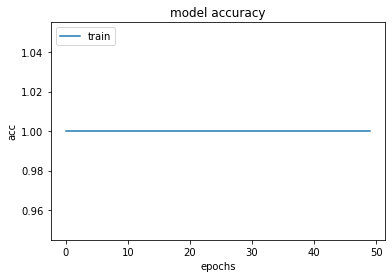

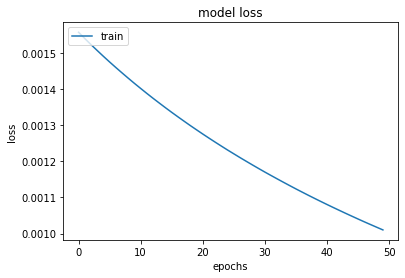

In [41]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_accuracy.png')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_loss.png')
plt.show()

In [42]:
# evaluate the model
_, train_acc = model.evaluate(X_train, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

1/1 - 0s - loss: 0.0010 - acc: 1.0000
1/1 - 0s - loss: 2.1267 - acc: 0.6957
Train: 1.000, Test: 0.6957


In [43]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
print(yhat_probs)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs,axis=1)
print(yhat_classes)
# reduce to 1d array
#yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 1]

[[8.6694081e-07 9.9999917e-01]
 [8.6621446e-07 9.9999917e-01]
 [8.3567261e-07 9.9999917e-01]
 [8.6695002e-07 9.9999917e-01]
 [8.6694655e-07 9.9999917e-01]
 [8.3552351e-07 9.9999917e-01]
 [8.6684224e-07 9.9999917e-01]
 [8.6702107e-07 9.9999917e-01]
 [8.6729733e-07 9.9999917e-01]
 [8.6694428e-07 9.9999917e-01]
 [8.6679415e-07 9.9999917e-01]
 [8.3704703e-07 9.9999917e-01]
 [8.6697406e-07 9.9999917e-01]
 [8.6695684e-07 9.9999917e-01]
 [8.6678381e-07 9.9999917e-01]
 [8.6704051e-07 9.9999917e-01]
 [8.3926767e-07 9.9999917e-01]
 [8.3581403e-07 9.9999917e-01]
 [8.5926365e-07 9.9999917e-01]
 [8.6695570e-07 9.9999917e-01]
 [8.6696258e-07 9.9999917e-01]
 [8.6698554e-07 9.9999917e-01]
 [8.6698782e-07 9.9999917e-01]]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [44]:
import numpy as np
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels

array([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1])

In [45]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, yhat_classes)
cm

array([[ 0,  7],
       [ 0, 16]])

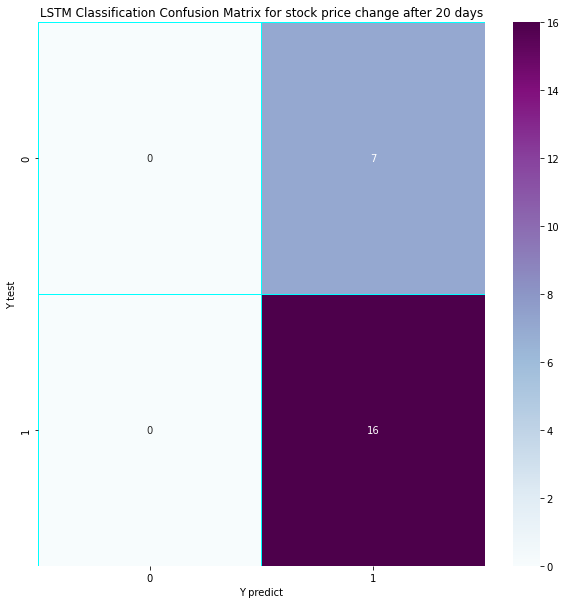

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix for stock price change after 20 days')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.savefig('LSTM Classification 20 days.png')
plt.show()

In [51]:
1+1

2